In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class PCA():
    """
    Train the model using PCA
    """
    def fit(self, X, normalize=True, components=20):
        if components > X.shape[1] or components <=0:
            raise ValueError("Number of Components should be between [1, {0}]".format(X.shape[1]))
        if normalize:
            X = (X - np.min(X)) / (np.max(X) - np.min(X))
        
        self.mean_X = np.mean(X, axis=0)
        self.centered_X = X - self.mean_X
        
        self.covariance_X = np.dot(self.centered_X.T, self.centered_X) / X.shape[0]
        
        # perform SVD on the covariance matrix
        self.components, self.singular_values, v = np.linalg.svd(self.covariance_X)
        
        # sort sigular values and components
        idx = np.argsort(self.singular_values)[::-1]
        self.singular_values = self.singular_values[idx]
        self.components = self.components[:, idx]
    
        self.reduced_components = self.components[:, 0:components]
        self.encoded_X = np.dot(self.centered_X, self.reduced_components)
        
        self.decoded_X = np.dot(self.encoded_X, self.reduced_components.T) + self.mean_X 
    
    def compute_new_encoded_X(self, X, normalize=True):
        """
        Compute encoded X
        """
        if normalize:
            X = (X - np.min(X)) / (np.max(X) - np.min(X))
        
        self.new_centered_X = X - np.mean(X, axis=0)
        self.new_encoded_X = np.dot(self.new_centered_X, self.reduced_components)

In [3]:
class KMeans:
    def __init__(self, n_clusters=10, max_iter=100, random_state=42):
        if n_clusters <= 0:
            raise ValueError("n_cluster cannot be less or equal to 0.")
        self.n_cluster = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
    
    def fit(self, X, normalize=True):
        """
        Train the model using KMeans
        """
        self._X_rows = X.shape[0]
        self._X_cols = X.shape[1]
        
        np.random.seed(self.random_state)
        
        if self._X_rows == self.n_cluster: # deal with the case when number of rows is equal to number of clusters 
            self.labels = np.random.choice(self.n_cluster, self._X_rows, replace=False)
        else:
            self.labels = np.random.choice(self.n_cluster, self._X_rows, )
        
        if normalize:
            X = (X - np.min(X)) / (np.max(X) - np.min(X))
        
        self.centers = np.zeros((self.n_cluster, self._X_cols))
        
        self.iter = 0
        while self.iter <  self.max_iter:
            for i in range(self.n_cluster):
                X_i = X[self.labels == i, ]
                # if X is a vector, set center[i, 0] to X
                if X_i.ndim == 1:
                    self.centers[i, ] = X_i
                # if X is empty, set center[i, ] to a zero vector (better: not defined)
                elif X_i.size == 0:
                    self.centers[i, ] = np.zeros(self._X_cols)
                else:
                    self.centers[i, ] = np.mean(X_i, axis=0)
            
            # decide new groups
            new_labels = np.zeros(self._X_rows)
            for i in range(self._X_rows):
                dist = np.nansum(np.square((X[i] - self.centers)), axis=1)
                new_labels[i] = np.argmin(dist)
            
            # termination condition
            if np.array_equal(self.labels, new_labels):
                break
            else:
                self.labels = new_labels
                self.iter += 1
                
        # remove zero vectors (empty clusters) in centers 
        self.centers = self.centers[~np.all(self.centers == 0, axis=1)]
        # compute encoded X
        self.encoded_X = np.apply_along_axis(self._compute_dist, 1, X)
    
    def compute_new_encoded_X(self, X, normalize=True):
        """
        Compute encoded X
        """
        if normalize:
            X = (X - np.min(X)) / (np.max(X) - np.min(X))
        
        self.new_encoded_X = np.apply_along_axis(self._compute_dist, 1, X)
    
    def _compute_dist(self, row):
        return np.mean(np.square(row - self.centers), axis=1)

In [4]:
class LinearRegression():
    """
    Train the model using linear regression
    """
    def fit(self, X, y):
        # obtain the weights using pseudo-inverse matrix
        self.weights = np.linalg.pinv(X).dot(y)
        
    def predict(self, X):
        self.pred = X.dot(self.weights)
        
    def compute_error(self, y_vector, y_matrix):
        # compute mean square error
        self.MSE = np.mean(np.square(self.pred - y_matrix))
        
        # compute misclassification rate
        pred_class = np.argmax(self.pred, axis=1)
        self.MISS = sum(pred_class != y_vector) / len(pred_class)

In [5]:
# load data
X = np.loadtxt('input/mfeat-pix.txt')

# split the dataset into training data and test data
train_indices = [range(0 + 200*i, 100 + 200*i) for i in range(10)]
test_indices = [range(100 + 200*i, 200 + 200*i) for i in range(10)]

X_train = X[train_indices, ].reshape(1000, 240)
X_test = X[test_indices, ].reshape(1000, 240)

In [6]:
# extract encoded data from the first 20 components in a PCA model
PCA_20 = PCA()
PCA_20.fit(X_train, components=20)
X_train_new = np.column_stack((np.ones(X_train.shape[0]), PCA_20.encoded_X))

PCA_20.compute_new_encoded_X(X_test)
X_test_new = np.column_stack((np.ones(X_test.shape[0]), PCA_20.new_encoded_X))

In [7]:
# create class labels
nb_classes = 10
y_vector = np.array([i for i in range(10) for j in range(100)])
y_matrix = np.eye(nb_classes)[y_vector]

In [8]:
# fit a linear model to the training data
lr = LinearRegression()
lr.fit(X_train_new, y_matrix)
lr.predict(X_train_new)
lr.compute_error(y_vector, y_matrix)
print(lr.MSE, lr.MISS)

0.03660249923751108 0.067


In [9]:
# fit a linear model to the test data
lr.predict(X_test_new)
lr.compute_error(y_vector, y_matrix)
print(lr.MSE, lr.MISS)

0.037353243811863945 0.068


In [10]:
# set maximum number of features create empty vectors
k_max = X.shape[1]
train_MSE = np.zeros(k_max)
train_MISS = np.zeros(k_max)
test_MSE = np.zeros(k_max)
test_MISS = np.zeros(k_max)

In [11]:
# training models using different numbers of components
for i in range(k_max):
    PCA_mod = PCA()
    PCA_mod.fit(X_train, components=i+1)
    X_train_new = np.column_stack((np.ones(X_train.shape[0]), PCA_mod.encoded_X))

    PCA_mod.compute_new_encoded_X(X_test)
    X_test_new = np.column_stack((np.ones(X_test.shape[0]), PCA_mod.new_encoded_X))
    
    lr = LinearRegression()
    lr.fit(X_train_new, y_matrix)
    lr.predict(X_train_new)
    lr.compute_error(y_vector, y_matrix)
    train_MSE[i] = lr.MSE
    train_MISS[i] = lr.MISS
    
    lr.predict(X_test_new)
    lr.compute_error(y_vector, y_matrix)
    test_MSE[i] = lr.MSE
    test_MISS[i] = lr.MISS

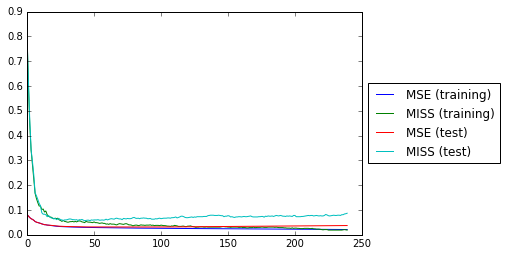

In [12]:
# plot MSE and MISS
plt.plot(train_MSE)
plt.plot(train_MISS)
plt.plot(test_MSE)
plt.plot(test_MISS)

plt.legend(['MSE (training)', 'MISS (training)', 'MSE (test)', 'MISS (test)'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [13]:
log_train_MSE = np.log(train_MSE)
log_train_MISS = np.log(train_MISS)
log_test_MSE = np.log(test_MSE)
log_test_MISS = np.log(test_MISS)

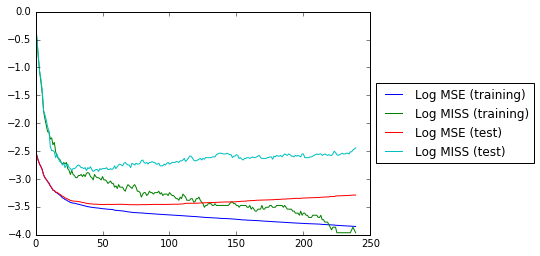

In [14]:
plt.plot(log_train_MSE)
plt.plot(log_train_MISS)
plt.plot(log_test_MSE)
plt.plot(log_test_MISS)

plt.legend(['Log MSE (training)', 'Log MISS (training)', 'Log MSE (test)', 'Log MISS (test)'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:
# extract encoded data from 10 codebooks in a K-means model
KMeans_10 = KMeans(n_clusters=10)
KMeans_10.fit(X_train)
X_train_new = np.column_stack((np.ones(X_train.shape[0]), KMeans_10.encoded_X))

In [16]:
lr = LinearRegression()
lr.fit(X_train_new, y_matrix)
lr.predict(X_train_new)
lr.compute_error(y_vector, y_matrix)
print(lr.MSE, lr.MISS)

0.04453238301553723 0.121


In [17]:
KMeans_10.compute_new_encoded_X(X_test)
X_test_new = np.column_stack((np.ones(X_test.shape[0]), KMeans_10.new_encoded_X))

In [18]:
lr = LinearRegression()
lr.fit(X_test_new, y_matrix)
lr.predict(X_test_new)
lr.compute_error(y_vector, y_matrix)
print(lr.MSE, lr.MISS)

0.04421202142534717 0.118


In [19]:
# set maximum number of features and create empty vectors
k_max = 800
train_MSE = np.zeros(k_max)
train_MISS = np.zeros(k_max)
test_MSE = np.zeros(k_max)
test_MISS = np.zeros(k_max)

In [20]:
# training models using different numbers of codebooks
for i in range(k_max):
    KMeans_mod = KMeans(n_clusters=i+1)
    KMeans_mod.fit(X_train)
    X_train_new = np.column_stack((np.ones(X_train.shape[0]), KMeans_mod.encoded_X))
    
    KMeans_mod.compute_new_encoded_X(X_test)
    X_test_new = np.column_stack((np.ones(X_test.shape[0]), KMeans_mod.new_encoded_X))
    
    lr = LinearRegression()
    lr.fit(X_train_new, y_matrix)
    lr.predict(X_train_new)
    lr.compute_error(y_vector, y_matrix)
    train_MSE[i] = lr.MSE
    train_MISS[i] = lr.MISS
    
    lr.predict(X_test_new)
    lr.compute_error(y_vector, y_matrix)
    test_MSE[i] = lr.MSE
    test_MISS[i] = lr.MISS

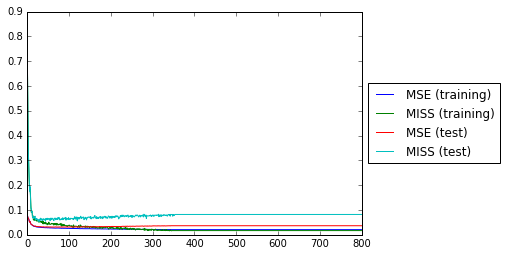

In [21]:
# plot MSE and MISS
plt.plot(train_MSE)
plt.plot(train_MISS)
plt.plot(test_MSE)
plt.plot(test_MISS)

plt.legend(['MSE (training)', 'MISS (training)', 'MSE (test)', 'MISS (test)'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [22]:
log_train_MSE = np.log(train_MSE)
log_train_MISS = np.log(train_MISS)
log_test_MSE = np.log(test_MSE)
log_test_MISS = np.log(test_MISS)

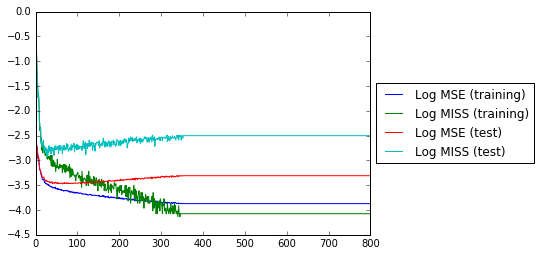

In [23]:
plt.plot(log_train_MSE)
plt.plot(log_train_MISS)
plt.plot(log_test_MSE)
plt.plot(log_test_MISS)

plt.legend(['Log MSE (training)', 'Log MISS (training)', 'Log MSE (test)', 'Log MISS (test)'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()